In [16]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

NEGATIVE_LABEL = 0
POSITIVE_LABEL = 1
BATCH_SIZE = 30
EPOCHS = 500
SEED = 2

### Read in data

In [17]:
from typing import Sequence, Tuple
from sklearn.utils import shuffle

# We read in the positive and negative corpora, assigning relative labels. As we'll be using binary cross entropy
# as our loss function we also assign a probability to each label of being positive (arbitrarily selected as the
# primary classifier)
def read_data() -> Tuple[Sequence[str], Sequence[int]]:
    data, labels = [], []
    with open('positive_corpus.txt') as positive_corpus:
        positive_data = list(map(lambda x: x.strip(), positive_corpus.readlines()))
        data += positive_data
        labels += [[POSITIVE_LABEL, 1]for _ in positive_data]
    with open('negative_corpus.txt') as negative_corpus:
        negative_data = list(map(lambda x: x.strip(), negative_corpus.readlines()))
        data += negative_data
        labels += [[NEGATIVE_LABEL, 0] for _ in negative_data]
    return shuffle(data, labels)

data, labels = read_data()
train_data, train_labels = data[:70], labels[:70]
dev_data, dev_labels = data[70:100], labels[70:100]
test_data, test_labels = data[100:130], labels[100:130]

### Create string diagrams (DisCoCat)

In [18]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Simplify diagrams by removing cups

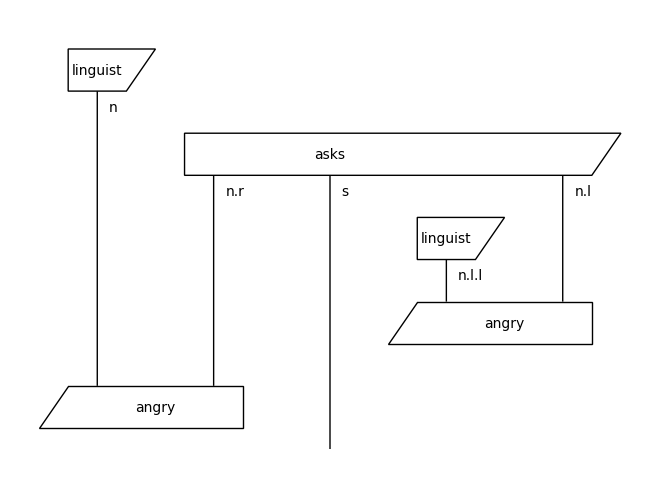

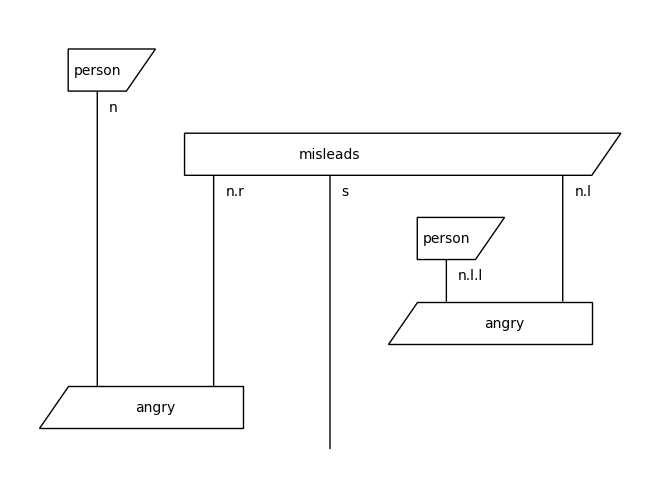

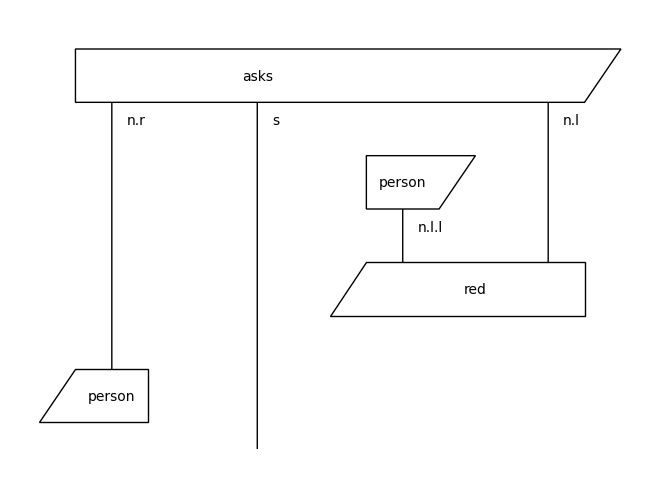

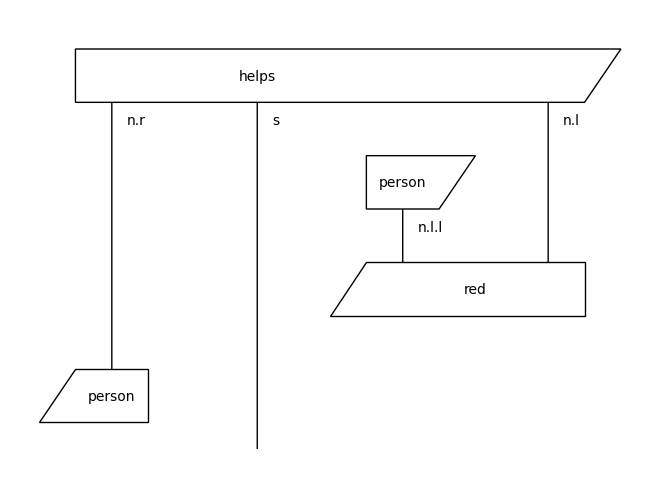

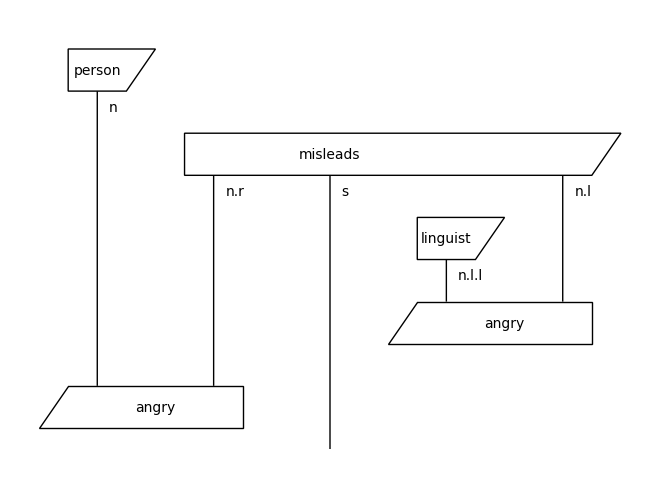

In [19]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

for diagram in train_diagrams[:5]:
    diagram.draw()

### Create Quantum circuits
Use a helper method to convert the string diagrams into IQP ansatz circuits using 3 rotations to represent an atomic type

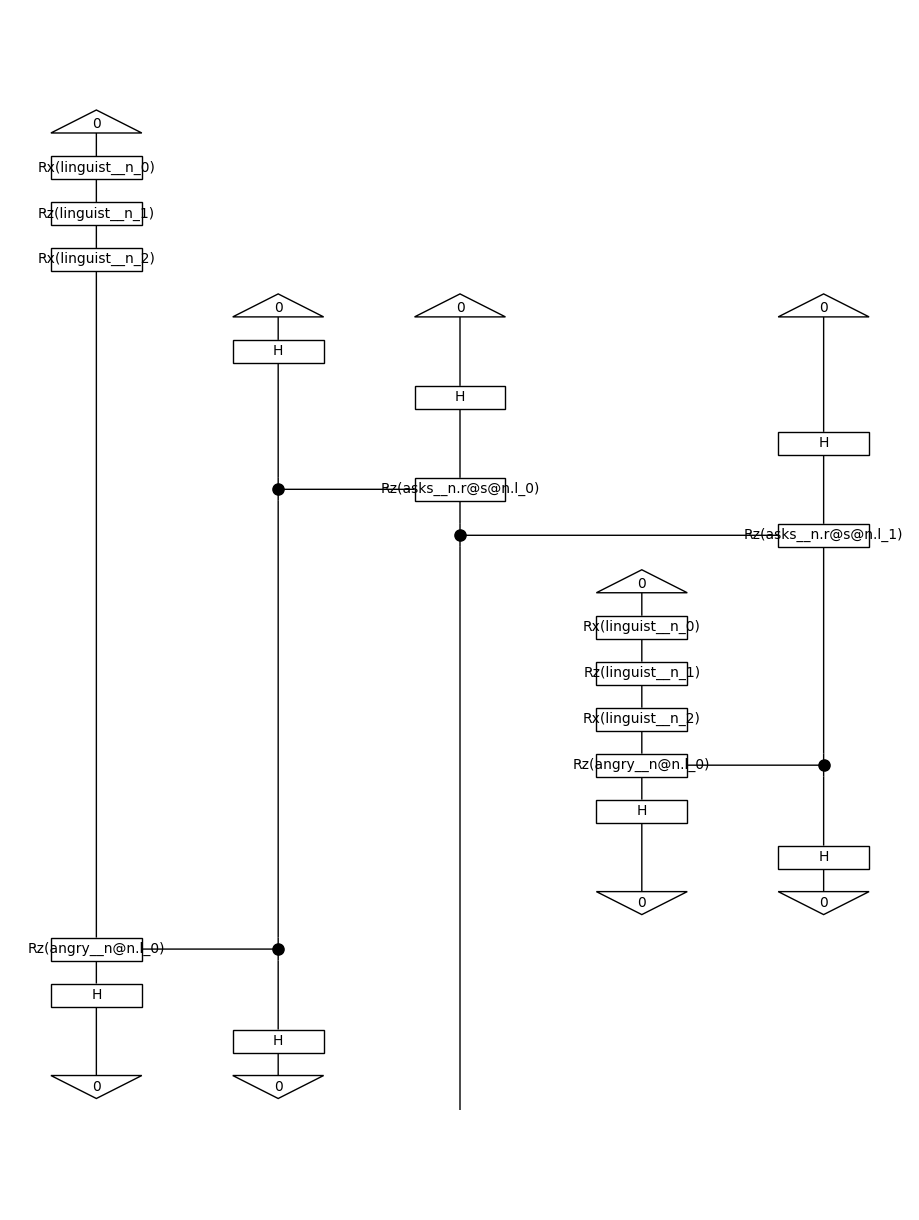

In [20]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

### Parameterise the circuits
Using the combined corpus add labelled parameters to the tket model that are consistent in all circuits (same parameter for the same word in each sentence)

In [21]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits+dev_circuits+test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

### Define evaluation functions (loss and accuracy)

In [22]:
import numpy as np

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

### Create trainer
Create a trainer using classical SPSA optimisation and the predefined train data. Use the dev data for in training evaluation.

In [23]:
from lambeq import QuantumTrainer, Dataset, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

### Train data

In [24]:
trainer.fit(train_dataset, val_dataset, logging_step=12)

Epoch 1:    train/loss: 2.9616   valid/loss: 2.1720   train/acc: 0.4929   valid/acc: 0.5000
Epoch 12:   train/loss: 1.5503   valid/loss: 1.2255   train/acc: 0.4857   valid/acc: 0.5000
Epoch 24:   train/loss: 1.7019   valid/loss: 1.2559   train/acc: 0.4857   valid/acc: 0.5000
Epoch 36:   train/loss: 1.0295   valid/loss: 0.9233   train/acc: 0.5214   valid/acc: 0.5000
Epoch 48:   train/loss: 1.6786   valid/loss: 1.4908   train/acc: 0.4929   valid/acc: 0.5000
Epoch 60:   train/loss: 1.2998   valid/loss: 1.4620   train/acc: 0.5000   valid/acc: 0.5000
Epoch 72:   train/loss: 1.1462   valid/loss: 1.0293   train/acc: 0.5143   valid/acc: 0.5167
Epoch 84:   train/loss: 0.9458   valid/loss: 0.8352   train/acc: 0.4857   valid/acc: 0.5000
Epoch 96:   train/loss: 0.8303   valid/loss: 0.8569   train/acc: 0.5071   valid/acc: 0.5333
Epoch 108:  train/loss: 0.7701   valid/loss: 0.7415   train/acc: 0.5000   valid/acc: 0.5333
Epoch 120:  train/loss: 0.7702   valid/loss: 0.7594   train/acc: 0.5071   valid/

Test accuracy: 0.48333333333333334


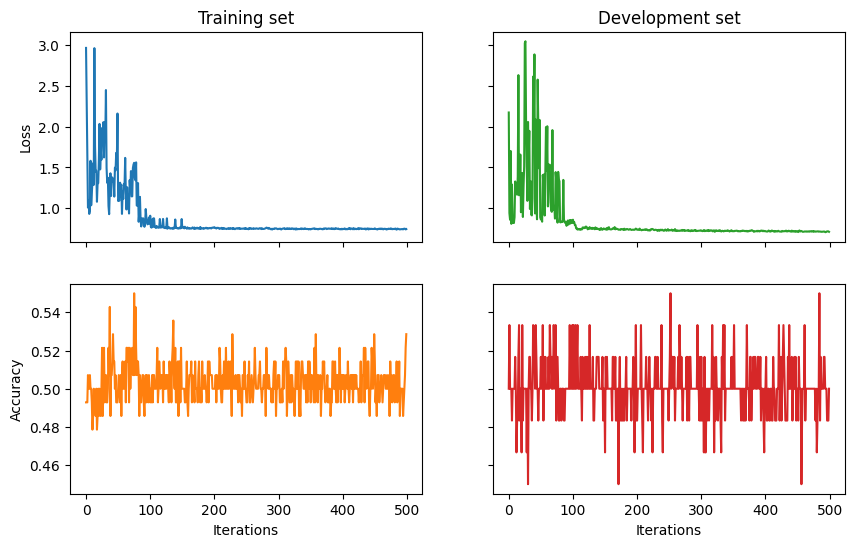

In [25]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)

### Run test set on physical device and compare accuracy to simulation

In [30]:
from pytket.extensions.qiskit import IBMQBackend
physical_backend = IBMQBackend('ibm_oslo')
physical_backend_config = {
    'backend': physical_backend,
    'compilation': physical_backend.default_compilation_pass(2),
    'shots': 8192
}
model.save('checkpoint')
physical_model = TketModel.from_checkpoint('checkpoint', backend_config=physical_backend_config)
test_acc = acc(physical_model(test_circuits), test_labels)
print('Test accuracy:', test_acc)

Job Status: job has successfully run
Test accuracy: 0.5
